In [ ]:
%load_ext ipython_pytest

<center>
    
# Intro to Pytest + AssertPy + Factory Boy
    
<br>
    
### Rodrigo Ferreira de Souza 

</center>

#### LinkedIn:
https://www.linkedin.com/in/rodfersou/
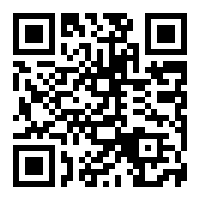

#### Github:
https://github.com/rodfersou
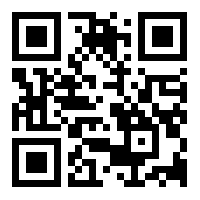

## About me

* Curious by nature
* 17 years of experience with multiple:
  * Programming Languages
  * Databases
  * Frameworks
  * APIs
  * Business domains

* Education:
  * 2001 - Data Processing - Associate's degree
  * 2006 - Computer Engineer - Bachelor's degree
  * 2009 - Software Engineer and Data Base - Postgraduate degree
  * 2013 - Web Development - Postgraduate degree

## Why Software Testing is Important?
https://www.guru99.com/software-testing-introduction-importance.html#2

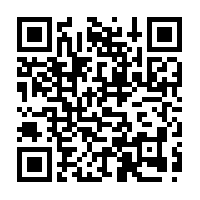

> Testing is important because software bugs could be expensive or even dangerous. Software bugs can potentially cause monetary and human loss, and history is full of such examples.

* `Software Testing` is the Warranty of your Product
* Avoid to insert new bugs with test cases
* You make sure that the basic requirements are set
* Get conficence in the development cycle

## Unittest

> The unittest unit testing framework was originally inspired by `JUnit` and has a similar flavor as major unit testing frameworks in other languages. It supports test automation, sharing of setup and shutdown code for tests, aggregation of tests into collections, and independence of the tests from the reporting framework.

`Unittest` is the standard way to write tests, shipped with Python itself, inspired by `JUnit`

Unittest

In [ ]:
%%pytest
import unittest

class UnittestTests(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        cls.my_fixture = {1: 2}

    def test_1_in_fixture(self):
        self.assertIn(1, self.my_fixture)

    def test_a_not_in_fixture(self):
        self.assertNotIn('a', self.my_fixture)

## Pytest

> The pytest framework makes it easy to write small tests, yet scales to support complex functional testing for applications and libraries.

`Pytest` is an attempt to make test more simple, what we call Pythonic

Pytest

In [ ]:
%%pytest
import pytest

@pytest.fixture
def manager(request):
    return {1: 2}

def test_1_in_manager(manager):
    assert 1 in manager

def test_a_not_in_manager(manager):
    assert 'a' not in manager

## AssertPy

> Simple assertions library for unit testing in Python with a nice fluent API.

`AssertPy` do another step forward to make tests more legible:
* You write like good English
* Easy for everyone in the team to understand what the test do, Frontend, Backend, Manager, Client

AssertPy

In [ ]:
%%pytest
from assertpy import assert_that
import pytest
 
@pytest.fixture
def manager(request):
    return {1: 2}

def test_1_in_manager(manager):
    assert_that(manager).contains(1)

def test_a_not_in_manager(manager):
    assert_that(manager).does_not_contain('a')

## Factory Boy

> factory_boy is a fixtures replacement based on `thoughtbot’s factory_bot`.

`Factory Boy` focus on give you the hability to create better fixtures
* Deal with random data (let the CI find wrong combinations for you)
* You can tie the fixture with your `SQL Alchemy` model or `MongoEngine` model

## Something to test
### Rock Paper Scissors Game
https://github.com/rodfersou/jakenpo

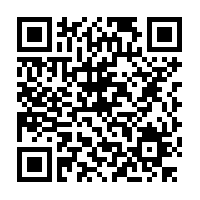

Something to test - Rock Paper Scissors Game

In [ ]:
from enum import Enum, unique

@unique
class Winner(Enum):
    PLAYER1 = "PLAYER1"
    PLAYER2 = "PLAYER2"
    DEUCE   = "DEUCE"

@unique
class Choice(Enum):
    ROCK    = "ROCK"
    PAPER   = "PAPER"
    SCISSOR = "SCISSOR"

Something to test - Rock Paper Scissors Game

In [ ]:
GAME_MAPPING = {
    Choice.ROCK: {
        Choice.SCISSOR: Winner.PLAYER1,
        Choice.ROCK: Winner.DEUCE,
        Choice.PAPER: Winner.PLAYER2,
    },
    Choice.PAPER: {
        Choice.ROCK: Winner.PLAYER1,
        Choice.PAPER: Winner.DEUCE,
        Choice.SCISSOR: Winner.PLAYER2,
    },
    Choice.SCISSOR: {
        Choice.PAPER: Winner.PLAYER1,
        Choice.SCISSOR: Winner.DEUCE,
        Choice.ROCK: Winner.PLAYER2,
    },
}

Something to test - Rock Paper Scissors Game

In [ ]:
from collections import defaultdict
from dataclasses import dataclass, field
from typing import DefaultDict

@dataclass
class Match:
    rounds: int = 0
    matches: DefaultDict[Winner, int] = field(default_factory=lambda: defaultdict(int))

    def round(self, choice_player1: Choice, choice_player2: Choice) -> str:
        winner = GAME_MAPPING[choice_player1][choice_player2]

        self.rounds += 1
        self.matches[winner] += 1

        return winner.value

    @property
    def winner(self) -> str:
        if self.matches[Winner.PLAYER1] == self.matches[Winner.PLAYER2]:
            return Winner.DEUCE
        inverted_matches = [(v, k) for k, v in self.matches.items()]
        return max(inverted_matches)[1].value

Something to test - Rock Paper Scissors Game

In [ ]:
from jakenpo import Choice, Match

match = Match()

print("Round 1   =>   (ROCK,    PAPER  )   =>  ", match.round(Choice.ROCK, Choice.PAPER))
print("Round 2   =>   (SCISSOR, PAPER  )   =>  ", match.round(Choice.SCISSOR, Choice.PAPER))
print("Round 3   =>   (ROCK,    SCISSOR)   =>  ", match.round(Choice.ROCK, Choice.SCISSOR))
print()
print(f"Winner in {match.rounds} rounds: {match.winner}")

## One more nice feature of Pytest - Parameters

In [ ]:
%%pytest
from assertpy import assert_that
from jakenpo import Choice, Match, Winner

import pytest

TESTDATA = [
    (Choice.ROCK, Choice.ROCK,    Winner.DEUCE.value),   (Choice.PAPER, Choice.PAPER,   Winner.DEUCE.value),   (Choice.SCISSOR, Choice.SCISSOR, Winner.DEUCE.value),
    (Choice.ROCK, Choice.PAPER,   Winner.PLAYER2.value), (Choice.PAPER, Choice.ROCK,    Winner.PLAYER1.value), (Choice.SCISSOR, Choice.ROCK,    Winner.PLAYER2.value),
    (Choice.ROCK, Choice.SCISSOR, Winner.PLAYER1.value), (Choice.PAPER, Choice.SCISSOR, Winner.PLAYER2.value), (Choice.SCISSOR, Choice.PAPER,   Winner.PLAYER1.value),
]


@pytest.mark.parametrize("choice_player1,choice_player2,winner", TESTDATA)
def test_all_rounds(choice_player1, choice_player2, winner):
    match = Match()
    assert_that(
        match.round(choice_player1, choice_player2)
    ).is_equal_to(winner)

## Factory Boy in action

In [ ]:
%%pytest
from assertpy import assert_that
from factory import DictFactory, Faker
from jakenpo import Choice, Match, GAME_MAPPING


class ChoicesFactory(DictFactory):
    player1 = Faker("random_element", elements=list(Choice))
    player2 = Faker("random_element", elements=list(Choice))


def test_random_round():
    match = Match()
    
    choices = ChoicesFactory.build()
    winner = GAME_MAPPING[choices["player1"]][choices["player2"]].value
    
    print(choices, winner)

    assert_that(
        match.round(*choices.values())
    ).is_equal_to(winner)

Factory Boy in action

In [ ]:
%%pytest
from assertpy import assert_that
from collections import defaultdict
from factory import DictFactory, Faker
from jakenpo import Choice, Match, GAME_MAPPING

class ChoicesFactory(DictFactory):
    player1 = Faker("random_element", elements=list(Choice))
    player2 = Faker("random_element", elements=list(Choice)

def test_who_wins():
    match = Match()
    many_choices = ChoicesFactory.build_batch(5)
    
    players_wins = defaultdict(int)
    for choices in many_choices:
        winner = GAME_MAPPING[choices["player1"]][choices["player2"]].value
        players_wins[winner] += 1
        assert_that(match.round(*choices.values())).is_equal_to(winner)
    
    assert_that(match).has_rounds(5)
    
    inverted_players_wins = [(v, k) for k, v in players_wins.items()]
    winner = max(inverted_players_wins)[1]
    assert_that(match).has_winner(winner)

## More examples of AssertPy
https://github.com/assertpy/assertpy

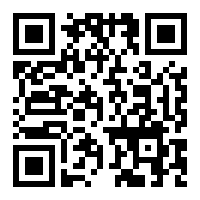

More examples of AssertPy
### Strings

In [ ]:
assert_that('foo').is_length(3)
assert_that('foo').is_not_empty()
assert_that('foo').is_alpha()
assert_that('123').is_digit()
assert_that('foo').is_lower()
assert_that('FOO').is_upper()
assert_that('foo').is_equal_to('foo')
assert_that('foo').is_not_equal_to('bar')

assert_that('foo').contains('f')
assert_that('foo').contains('f','oo')
assert_that('foo').does_not_contain('x')
assert_that('foo').contains_only('f','o')

More examples of AssertPy  
Strings

In [ ]:
assert_that('foo').contains_duplicates()
assert_that('fox').does_not_contain_duplicates()

assert_that('foo').is_in('foo','bar','baz')
assert_that('foo').is_not_in('boo','bar','baz')
assert_that('foo').is_subset_of('abcdefghijklmnopqrstuvwxyz')

assert_that('foo').starts_with('f')
assert_that('foo').ends_with('oo')

assert_that('foo').matches(r'\w')
assert_that('123-456-7890').matches(r'\d{3}-\d{3}-\d{4}')
assert_that('foo').does_not_match(r'\d+')

More examples of AssertPy  
### Numbers

In [ ]:
assert_that(0).is_zero()
assert_that(1).is_not_zero()
assert_that(1).is_positive()
assert_that(-1).is_negative()

assert_that(123).is_equal_to(123)
assert_that(123).is_not_equal_to(456)

assert_that(123).is_greater_than(100)
assert_that(123).is_greater_than_or_equal_to(123)
assert_that(123).is_less_than(200)
assert_that(123).is_less_than_or_equal_to(200)
assert_that(123).is_between(100, 200)
assert_that(123).is_close_to(100, 25)

assert_that(1).is_in(0,1,2,3)
assert_that(1).is_not_in(-1,-2,-3)

More examples of AssertPy  
### Lists

In [ ]:
assert_that(['a','b']).is_length(2)
assert_that(['a','b']).is_not_empty()
assert_that(['a','b']).is_equal_to(['a','b'])
assert_that(['a','b']).is_not_equal_to(['b','a'])

assert_that(['a','b']).contains('a')
assert_that(['a','b']).contains('b','a')
assert_that(['a','b']).does_not_contain('x','y')
assert_that(['a','b']).contains_only('a','b')
assert_that(['a','a']).contains_only('a')
assert_that(['a','b','c']).contains_sequence('b','c')
assert_that(['a','b']).is_subset_of(['a','b','c'])
assert_that(['a','b','c']).is_sorted()
assert_that(['c','b','a']).is_sorted(reverse=True)

assert_that(['a','x','x']).contains_duplicates()
assert_that(['a','b','c']).does_not_contain_duplicates()

assert_that(['a','b','c']).starts_with('a')
assert_that(['a','b','c']).ends_with('c')

More examples of AssertPy  
#### Lists Flattening

In [ ]:
people = [['Fred', 'Smith'], ['Bob', 'Barr']]
assert_that(people).extracting(0).is_equal_to(['Fred','Bob'])
assert_that(people).extracting(-1).is_equal_to(['Smith','Barr'])

More examples of AssertPy  
### Dicts

In [ ]:
assert_that({'a':1,'b':2}).is_length(2)
assert_that({'a':1,'b':2}).is_not_empty()
assert_that({'a':1,'b':2}).is_equal_to({'a':1,'b':2})
assert_that({'a':1,'b':2}).is_equal_to({'b':2,'a':1})
assert_that({'a':1,'b':2}).is_not_equal_to({'a':1,'b':3})

assert_that({'a':1,'b':2}).contains('a')
assert_that({'a':1,'b':2}).contains('b','a')
assert_that({'a':1,'b':2}).does_not_contain('x')
assert_that({'a':1,'b':2}).does_not_contain('x','y')
assert_that({'a':1,'b':2}).contains_only('a','b')
assert_that({'a':1,'b':2}).is_subset_of({'a':1,'b':2,'c':3})

More examples of AssertPy  
Dicts

In [ ]:
# contains_key() is just an alias for contains()
assert_that({'a':1,'b':2}).contains_key('a')
assert_that({'a':1,'b':2}).contains_key('b','a')

# does_not_contain_key() is just an alias for does_not_contain()
assert_that({'a':1,'b':2}).does_not_contain_key('x')
assert_that({'a':1,'b':2}).does_not_contain_key('x','y')

assert_that({'a':1,'b':2}).contains_value(1)
assert_that({'a':1,'b':2}).contains_value(2,1)
assert_that({'a':1,'b':2}).does_not_contain_value(3)
assert_that({'a':1,'b':2}).does_not_contain_value(3,4)

assert_that({'a':1,'b':2}).contains_entry({'a':1})
assert_that({'a':1,'b':2}).contains_entry({'a':1},{'b':2})
assert_that({'a':1,'b':2}).does_not_contain_entry({'a':2})
assert_that({'a':1,'b':2}).does_not_contain_entry({'a':2},{'b':1})

More examples of AssertPy  
#### Dict Key Assertions

In [ ]:
fred = {'first_name': 'Fred', 'last_name': 'Smith', 'shoe_size': 12}

assert_that(fred).has_first_name('Fred')
assert_that(fred).has_last_name('Smith')
assert_that(fred).has_shoe_size(12)

More examples of AssertPy

### Objects

Given `fred` is an instance of the following `Person` class:

In [ ]:
class Person(object):
    def __init__(self, first_name, last_name):
        self.first_name = first_name
        self.last_name = last_name

    @property
    def name(self):
        return '%s %s' % (self.first_name, self.last_name)

    def say_hello(self):
        return 'Hello, %s!' % self.first_name

More examples of AssertPy  
#### Matching an attribute, a property, and a method

In [ ]:
fred = Person('Fred','Smith')

assert_that(fred.first_name).is_equal_to('Fred')
assert_that(fred.name).is_equal_to('Fred Smith')
assert_that(fred.say_hello()).is_equal_to('Hello, Fred!')

#### Dynamic Assertions on Objects

In [ ]:
assert_that(fred).has_first_name('Fred')
assert_that(fred).has_name('Fred Smith')
assert_that(fred).has_say_hello('Hello, Fred!')

## More examples of Factory Boy
### Faker Providers

https://faker.readthedocs.io/en/master/providers.html

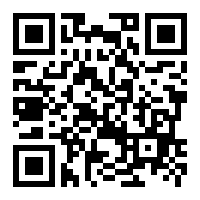

In [ ]:
from faker import Faker

faker = Faker()

print(faker.name())
print(faker.address())
print(faker.paragraph())  # Lorem ipsum
print(faker.company())

<center>

# Questions?

</center>

<center>
    
# Thankyou!!
    
<br>

### Rodrigo Ferreira de Souza

</center>

#### LinkedIn:
https://www.linkedin.com/in/rodfersou/
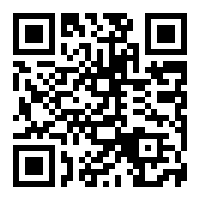

#### Github:
https://github.com/rodfersou
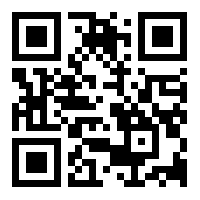